In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import recall_score, precision_score, roc_auc_score

In [2]:
df=pd.read_csv("evaluation metrics/AER_credit_card_data.csv")

In [3]:
df

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


# Data Preparation

In [4]:
df.loc[df.card=='yes','card']=1
df.loc[df.card=='no','card']=0

In [5]:
df.card=pd.to_numeric(df.card)

# Q1 : Feature selection based on AUC

In [6]:
X=df.drop("card",1)
Y=df["card"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [7]:
num_vars=df.select_dtypes(include=np.number).columns[1:]
auc_df=pd.DataFrame({"col":num_vars,"auc_score":[np.nan]*len(num_vars)})

In [8]:
for i in num_vars:
    auc_df.loc[auc_df['col']==i,"auc_score"]=roc_auc_score(df['card'],df[i])

In [9]:
auc_df.sort_values('auc_score')

,col,auc_score
0,reports,0.282199
5,dependents,0.474228
6,months,0.482117
1,age,0.498625
7,majorcards,0.549911
8,active,0.582468
2,income,0.588890
4,expenditure,0.989736
3,share,0.989805


share has the highest AUC

# Training the model

In [10]:
x_vars=["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [11]:
X_train=pd.get_dummies(X_train[x_vars])
X_val=pd.get_dummies(X_val[x_vars])
X_test=pd.get_dummies(X_test[x_vars])

In [12]:
X_train

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner_no,owner_yes,selfemp_no,selfemp_yes
1105,3,40.50000,4.0128,0.000299,0.00000,1,12,1,17,1,0,1,0
431,1,32.33333,6.0000,0.000200,0.00000,4,18,1,4,0,1,1,0
407,1,29.16667,2.2000,0.038205,69.79333,0,49,1,7,1,0,1,0
1217,1,54.66667,7.2900,0.106536,647.20670,2,78,1,9,0,1,1,0
1133,0,25.00000,3.3984,0.000353,0.00000,2,29,0,4,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,0,53.00000,2.4500,0.017718,35.67500,0,3,1,11,0,1,1,0
1162,2,30.58333,2.5000,0.000480,0.00000,0,12,1,18,1,0,1,0
128,0,24.75000,1.8750,0.080708,126.02250,1,14,0,1,1,0,1,0
413,1,56.91667,3.4838,0.062895,182.09580,0,540,1,7,0,1,1,0


In [13]:
model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [14]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

# Q2 : AUC on Validation set

In [15]:
y_val_pred=model.predict(X_val)

In [16]:
roc_auc_score(y_val,y_val_pred)

0.9739783600107306

# Q3 : Precision and recall

In [17]:
threshold_list = np.linspace(0,1,100)


In [18]:
model.predict_proba(X_val).shape

(264, 2)

In [19]:
model.predict_proba(X_val)[10,:]

array([0.86163509, 0.13836491])

In [20]:
Y_val_pred = model.predict_proba(X_val)[:,1]

In [21]:
df_tresh=pd.DataFrame({"tresh":threshold_list,'precision':[np.nan]*len(threshold_list),'recall':[np.nan]*len(threshold_list)})
for i in threshold_list:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_pos=(Y_val_pred >= i)
    predict_neg=(Y_val_pred < i)
    
    tp=(predict_pos & actual_positive).sum()
    tn=(predict_neg & actual_negative).sum()
    
    fp=(predict_pos & actual_negative).sum()
    fn=(predict_neg & actual_positive).sum()
    
    
    df_tresh.loc[df_tresh.tresh==i,"precision"]=tp/(tp+fp)
    df_tresh.loc[df_tresh.tresh==i,"recall"]=tp/(tp+fn)

In [22]:
df_tresh[df_tresh.precision==df_tresh.recall]

,tresh,precision,recall
23,0.232323,0.976303,0.976303
24,0.242424,0.976303,0.976303
25,0.252525,0.976303,0.976303
26,0.262626,0.976303,0.976303
27,0.272727,0.976303,0.976303
28,0.282828,0.976303,0.976303
29,0.292929,0.976303,0.976303


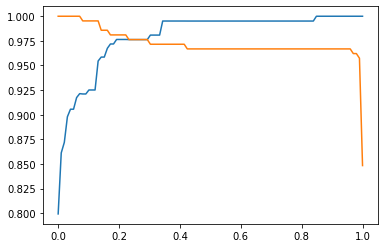

In [23]:
plt.plot(df_tresh.tresh,df_tresh.precision)
plt.plot(df_tresh.tresh,df_tresh.recall)

# Q4 : F1 score

F1 = 2 * P * R / (P + R)

In [24]:
df_tresh['F1_score']=2*(df_tresh.precision*df_tresh.recall)/(df_tresh.precision+df_tresh.recall)

In [25]:
df_tresh.sort_values('F1_score')

,tresh,precision,recall,F1_score
0,0.000000,0.799242,1.000000,0.888421
99,1.000000,1.000000,0.848341,0.917949
1,0.010101,0.861224,1.000000,0.925439
2,0.020202,0.871901,1.000000,0.931567
3,0.030303,0.897872,1.000000,0.946188
...,...,...,...,...
40,0.404040,0.995146,0.971564,0.983213
41,0.414141,0.995146,0.971564,0.983213
35,0.353535,0.995146,0.971564,0.983213
34,0.343434,0.995146,0.971564,0.983213


# Q5 : Kfold for evaluating model

In [26]:
from sklearn.model_selection import KFold

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [28]:
model=LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
df_auc=pd.DataFrame({"folds":[1,2,3,4,5],"AUC":[np.nan]*5})

In [29]:
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [30]:
a=0
for train_index, val_index in kf.split(X_train):
    a+=1
    #print("TRAIN:", train_index, "TEST:", val_index)
    X_train_, X_val_ = X_train.loc[train_index,], X_train.loc[val_index,]
    y_train_, y_val_ = y_train.loc[train_index,], y_train.loc[val_index,]
    model.fit(X_train_,y_train_)
    y_val_pred=model.predict_proba(X_val_)[:,1]
    df_auc.loc[df_auc.folds==a,'AUC']=roc_auc_score(y_val_,y_val_pred)

In [31]:
df_auc.AUC.std()

0.0034755108598963857

# Q6 : Kfold for choosing hyperparameters

In [32]:
c_params=[0.01, 0.1, 1, 10]

In [33]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [34]:
df_auc=pd.DataFrame({"folds":[1,2,3,4,5]*4,"AUC":[np.nan]*20,"c":c_params*5})

In [35]:
for c in c_params:
    LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    a=0
    for train_index, val_index in kf.split(X_train):
        a+=1
        #print("TRAIN:", train_index, "TEST:", val_index)
        X_train_, X_val_ = X_train.loc[train_index,], X_train.loc[val_index,]
        y_train_, y_val_ = y_train.loc[train_index,], y_train.loc[val_index,]
        model.fit(X_train_,y_train_)
        y_val_pred=model.predict_proba(X_val_)[:,1]
        df_auc.loc[(df_auc.folds==a) & (df_auc.c==c),'AUC']=roc_auc_score(y_val_,y_val_pred)

In [36]:
df_auc.groupby('c')['AUC'].mean()

c
0.01     0.996414
0.10     0.996414
1.00     0.996414
10.00    0.996414
Name: AUC, dtype: float64

In [37]:
df_auc.groupby('c')['AUC'].std()

c
0.01     0.003476
0.10     0.003476
1.00     0.003476
10.00    0.003476
Name: AUC, dtype: float64